In [1]:
# Load the .CSV file of the waveform
import csv
import os

import matplotlib.pyplot as plt
import numpy as np
import math

# Parameters
top_level=f'{os.getcwd()}/..'
path    = f'{top_level}/data/RefCurve_2023-08-15_1_192110.Wfm.csv'
size    = 100032 # Number of data points in the file
timeBin = 1E-3 # Unit of ns
freqBin = (0.5E+3/timeBin)/float(size//2) # Units of MHz
adcLsb  = 500.0/float(2**15) # units of mV

timeSteps = np.linspace(0, timeBin*(size-1), num=size)
waveformFp = np.zeros(shape=size, dtype=np.float32, order='C')
waveformAdc = np.zeros(shape=size, dtype=np.int16, order='C')

with open(path) as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONE)
    for i, row in enumerate(reader):
        waveformFp[i] = float(row[0])
        waveformAdc[i] = 100*int((waveformFp[i]*1E3)/adcLsb)

# Calculate the FFT  (full rate)
freqSteps = np.linspace(0, freqBin*(size//2-1), num=size//2)
freq = np.fft.fft(waveformAdc)/float(len(waveformAdc))
freq = freq[range(len(waveformAdc)//2)]
mag = 20.0*np.log10(np.abs(freq)/32767.0) # Units of dBFS

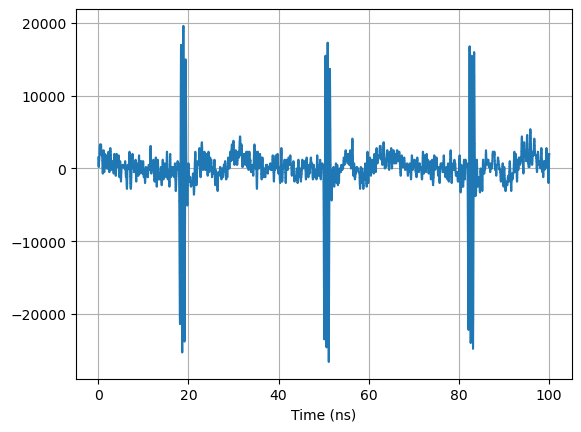

In [2]:
# Plot the time waveform (full rate)
plt.plot(timeSteps,waveformAdc)
plt.xlabel("Time (ns)")
plt.grid()

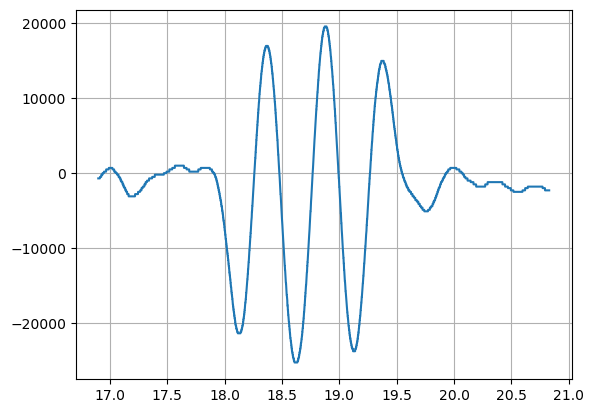

In [3]:
# Plot the time waveform butzoomed in  (full rate)
#first bunch
plt.plot(timeSteps[16900:20830],waveformAdc[16900:20830])
plt.grid()

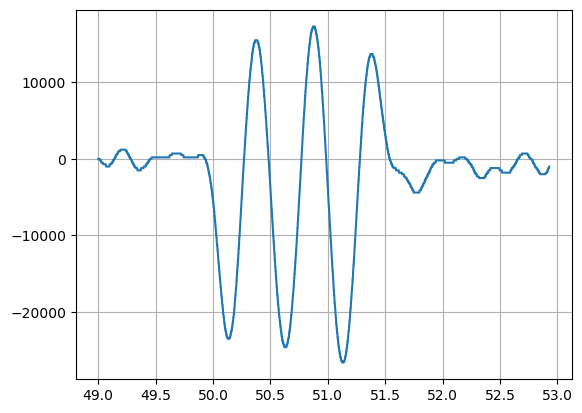

In [4]:
#second bunch
plt.plot(timeSteps[49000:52930],waveformAdc[49000:52930])
plt.grid()

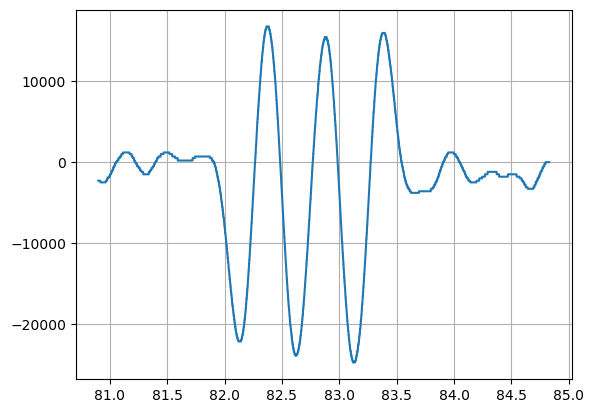

In [5]:
#3rd bunch
plt.plot(timeSteps[80900:84830],waveformAdc[80900:84830])
plt.grid()

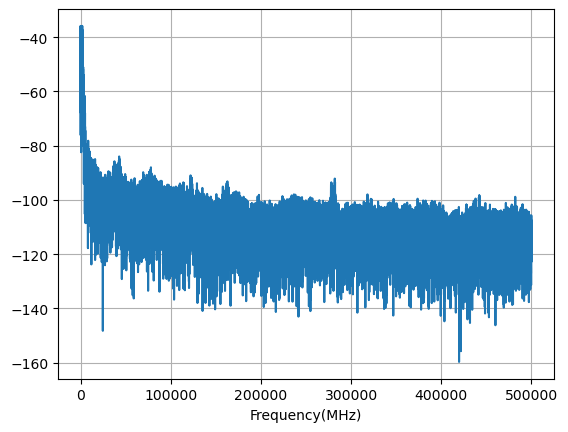

In [6]:
# Plot the FFT waveform  (full rate)
plt.plot(freqSteps,mag)
plt.xlabel("Frequency(MHz)")
plt.grid()

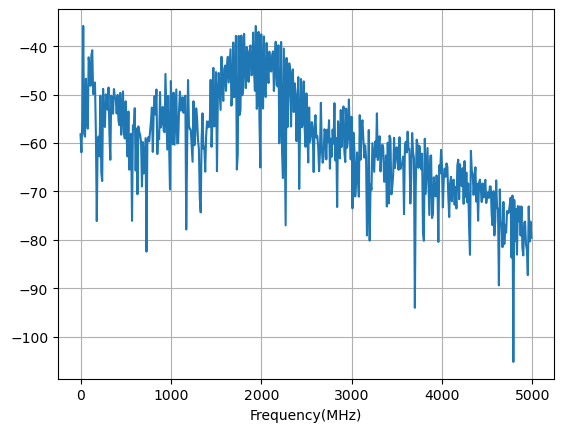

In [7]:
# Plot the FFT waveform but zoomed in (full rate)
plt.plot(freqSteps[:500],mag[:500])
plt.xlabel("Frequency(MHz)")
plt.grid()

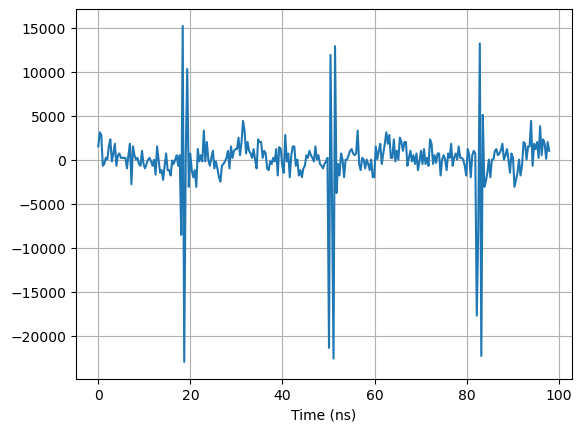

In [8]:
#  linear interpolation for this data at 3.054 GSPS
newTimeBin = 1.0/(0.509*6.0) # Unit of ns for 3.054 GSPS
newSize    = 300
newFreqBin = (0.5E+3/newTimeBin)/float(newSize//2) # Units of MHz
newTimeSteps = np.linspace(0, newTimeBin*(newSize-1), num=newSize)

newWaveformAdc = np.int16(np.interp(newTimeSteps, timeSteps, waveformAdc))
# Plot the time waveform (RFSoC rate)
plt.plot(newTimeSteps,newWaveformAdc)
plt.xlabel("Time (ns)")
plt.grid()

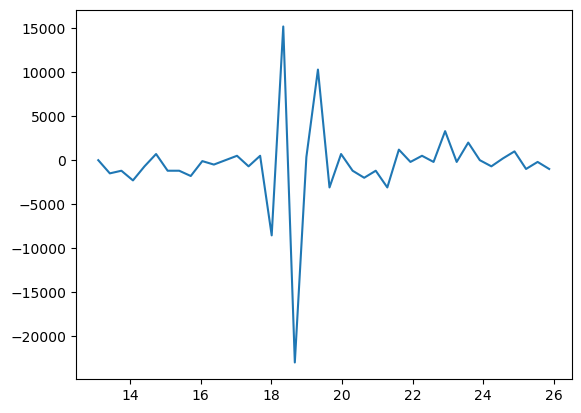

In [9]:
# Plot the time waveform but zoomed in (3.054 GSPS)
plt.plot(newTimeSteps[40:80],newWaveformAdc[40:80])

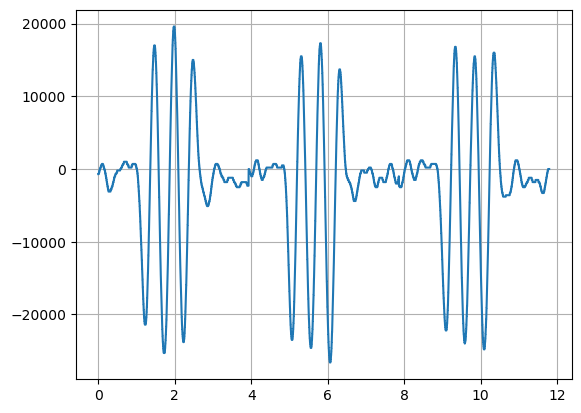

In [10]:
#concatenate 3 bunches every 4ns (full late)
threebunch=np.concatenate((waveformAdc[16900:20830],waveformAdc[49000:52930],waveformAdc[80900:84830]),axis=0)
plt.plot(timeSteps[0:11790],threebunch)
plt.grid()

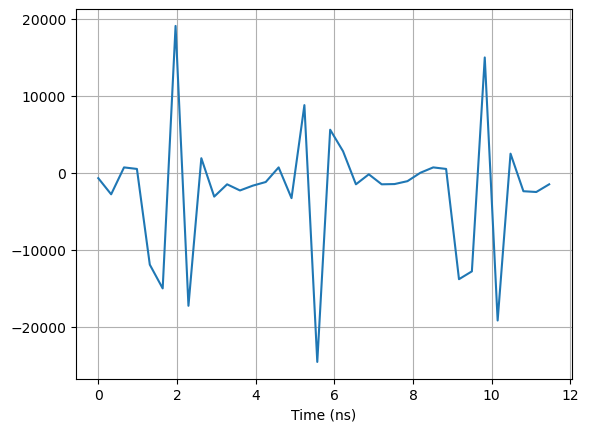

In [11]:
#  linear interpolation for this data at 3.054 GSPS
newTimeBin = 1.0/(0.509*6.0) # Unit of ns for 3.054 GSPS
newSize    = 36
newFreqBin = (0.5E+3/newTimeBin)/float(newSize//2) # Units of MHz
newTimeSteps_sim = np.linspace(0, newTimeBin*(newSize-1), num=newSize)

newWaveformAdc_sim = np.int16(np.interp(newTimeSteps_sim, timeSteps[0:11790], threebunch))
# Plot the time waveform (RFSoC rate)
plt.plot(newTimeSteps_sim,newWaveformAdc_sim)
plt.xlabel("Time (ns)")
plt.grid()

In [12]:
#randomly concatenate
def random_concat():
    arrays = [waveformAdc[16900:20830],waveformAdc[49000:52930],waveformAdc[80900:84830]]
    permutation = np.random.permutation(len(arrays))
    concatenated_array = np.concatenate([arrays[i] for i in permutation])
    newTimeBin = 1.0/(0.509*6.0) # Unit of ns for 3.054 GSPS
    newSize    = 36
    newFreqBin = (0.5E+3/newTimeBin)/float(newSize//2) # Units of MHz
    newTimeSteps_sim = np.linspace(0, newTimeBin*(newSize-1), num=newSize)
    newWaveformAdc_sim = np.int16(np.interp(newTimeSteps_sim, timeSteps[0:11790], concatenated_array))
    return newWaveformAdc_sim

Text(0.5, 0, 'time(ns)')

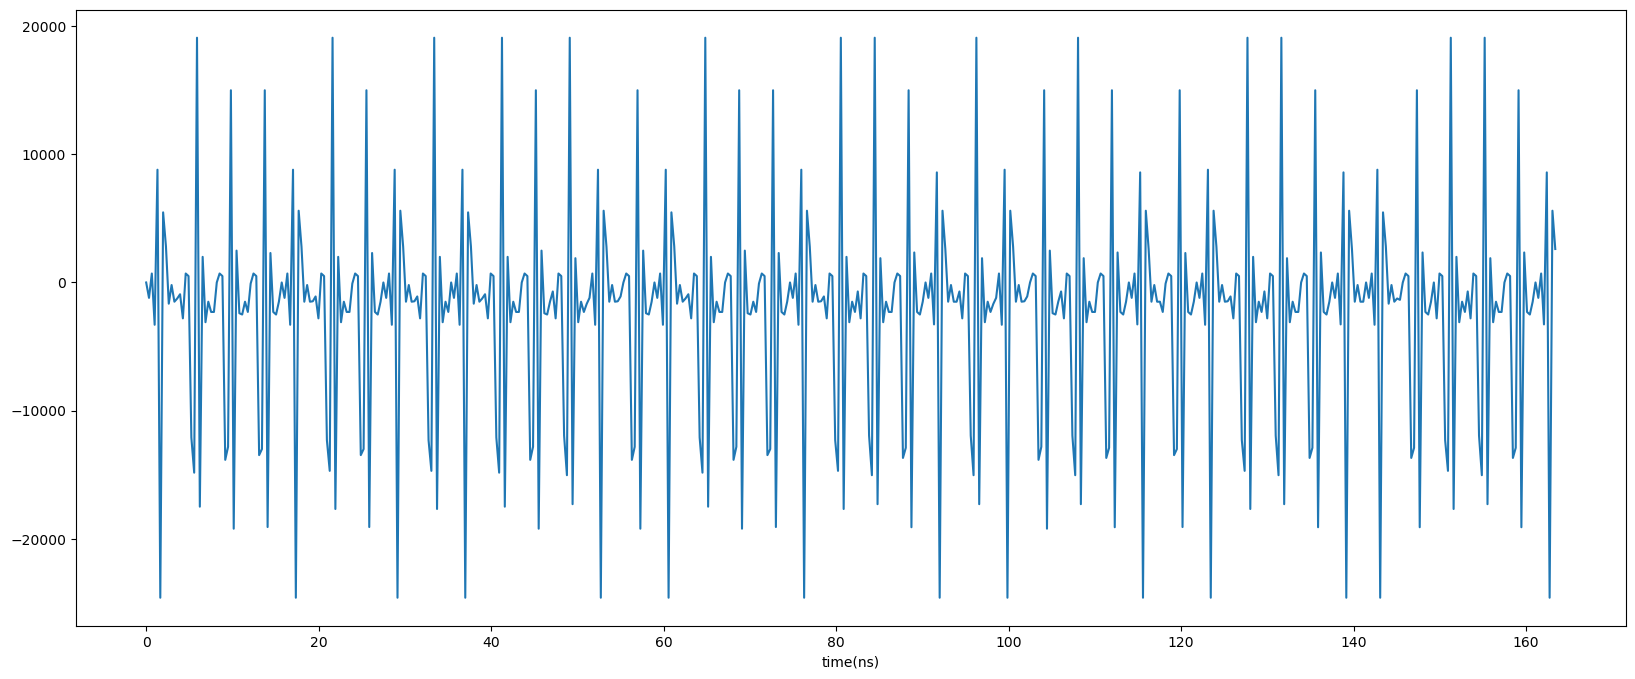

In [59]:
#make simulation waveform (3054MSPS)
simWave=np.concatenate([random_concat() for i in range(250)])
plt.figure(figsize=(20,8))
timepoints=np.arange(0,9000)*newTimeBin
plt.plot(timepoints[0:500],simWave[0:500])
plt.xlabel('time(ns)')

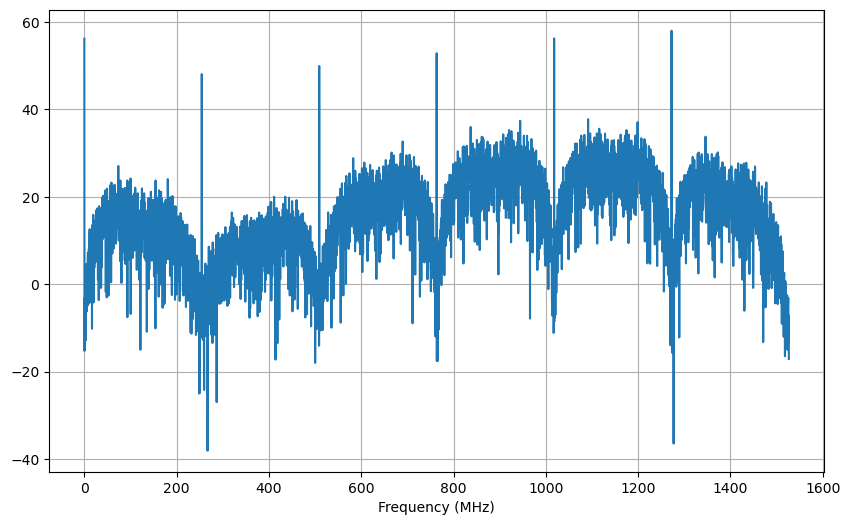

In [60]:
sample_rate = 3054e6
num_samples = 9000
time = np.arange(0, num_samples) / sample_rate
fft_result = np.fft.fft(simWave)
fft_result = fft_result[range(len(fft_result)//2)]
mag = 20.0*np.log10(np.abs(fft_result)/32767.0) # Units of dBFS
freq = np.fft.fftfreq(num_samples, 1 / sample_rate)
freq = freq[range(len(freq)//2)]
freq_mhz = freq / 1e6
plt.figure(figsize=(10, 6))
plt.plot(freq_mhz, mag)
plt.xlabel('Frequency (MHz)')
plt.grid()
plt.show()

In [61]:
# Write the RFDC data interpolated at 3.054 GSPS to file
path = f'{top_level}/data/RefCurve_3054MSPS.csv'
with open(path, 'w') as f:
    for smpl in simWave:
        f.write(f'{smpl}\n')